In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import random
%matplotlib inline

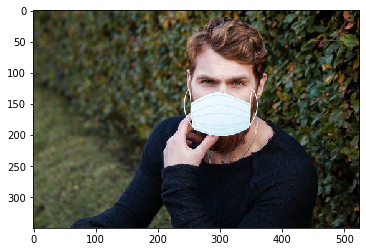

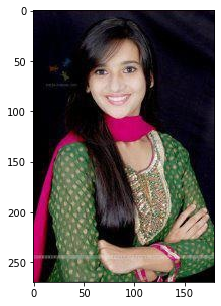

In [6]:
img1 = cv2.imread('C:\Hackathon\dataset/with mask/0-with-mask.jpg')
img1 = img1[:,:,::-1]
plt.imshow(img1)
plt.figure(figsize=(5,5))
img2 = cv2.imread('C:\Hackathon\dataset/without mask/0.jpg')
img2 = img2[:,:,::-1]

plt.imshow(img2)
plt.show()

In [10]:

    os.mkdir('/Mask/')
    os.mkdir('Mask/training/')
    os.mkdir('Mask/training/With Mask/')
    os.mkdir('Mask/training/Without Mask/')
    os.mkdir('Mask/testing/')
    os.mkdir('Mask/testing/With Mask/')
    os.mkdir('Mask/testing/Without Mask/')


FileExistsError: [WinError 183] Cannot create a file when that file already exists: '/Mask/'

In [11]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE = 1.0):
  '''
  This function will split the current data into two different folders.
  One for Training and one for Testing
  '''
  sources_list = os.listdir(SOURCE)
  random.sample(sources_list, len(sources_list))
  split_len = int(round(len(sources_list)*SPLIT_SIZE))

  for i in range(split_len):
    if os.path.getsize(SOURCE + sources_list[i]) > 1:
      copyfile(os.path.join(SOURCE, sources_list[i]), os.path.join(TRAINING, sources_list[i]))

  for i in range(split_len, len(sources_list)):
    if os.path.getsize(SOURCE + sources_list[i]) > 1:
      copyfile(os.path.join(SOURCE, sources_list[i]), os.path.join(TESTING, sources_list[i]))

MASK_SOURCE_DIR = "C:\Hackathon/dataset/with mask/"
TRAINING_MASK_DIR = "Mask/training/With Mask/"
TESTING_MASK_DIR = "Mask/testing/With Mask/"
NONMASK_SOURCE_DIR = "C:\Hackathon\dataset\without mask/"
TRAINING_NONMASK_DIR = "Mask/training/Without Mask/"
TESTING_NONMASK_DIR = "Mask/testing/Without Mask/"

split_data(MASK_SOURCE_DIR, TRAINING_MASK_DIR, TESTING_MASK_DIR, SPLIT_SIZE = 0.9)
split_data(NONMASK_SOURCE_DIR, TRAINING_NONMASK_DIR, TESTING_NONMASK_DIR, SPLIT_SIZE = 0.9)


FileNotFoundError: [Errno 2] No such file or directory: 'Mask/training/With Mask/0-with-mask.jpg'

In [12]:
def load_data(dir_path):
  '''
  This function will load training and validation data.
  '''
  datagen = ImageDataGenerator(rescale=1.0/255,
                                rotation_range = 40,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                zoom_range = 0.2,
                                shear_range = 0.2,
                                horizontal_flip = True,
                                fill_mode = 'nearest'
                                )

  generator = datagen.flow_from_directory(dir_path,
                                          batch_size = 10,
                                          class_mode = 'categorical',
                                          target_size = (150,150))
  return generator

In [15]:
train_generator = load_data('C:/Hackathon/Face-Mask-Detection/Face-Mask-Detection/Mask/training')
validation_generator = load_data('C:/Hackathon/Face-Mask-Detection/Face-Mask-Detection/Mask/testing')

Found 1232 images belonging to 2 classes.
Found 144 images belonging to 2 classes.


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

In [6]:
pretrained_model = VGG16(
    input_shape = (150,150,3),
    weights = 'imagenet',
    include_top = False
)
pretrained_model.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [7]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
last_layer_output = pretrained_model.get_layer('block5_pool').output
x = Flatten()(last_layer_output)
x = Dense(512, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(pretrained_model.input, x)

In [29]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.99):
      print("\nReached 99 % accuracy")
      self.model.stop_training = True
callbacks = myCallback()

In [32]:
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    epochs = 60,
                    callbacks=[callbacks])

Epoch 1/60
124/124 [==============================] - 18s 144ms/step - loss: 0.3378 - accuracy: 0.8958 - val_loss: 0.1451 - val_accuracy: 0.9420
Epoch 2/60
124/124 [==============================] - 18s 142ms/step - loss: 0.1065 - accuracy: 0.9588 - val_loss: 0.0282 - val_accuracy: 0.9928
Epoch 3/60
124/124 [==============================] - 17s 141ms/step - loss: 0.0859 - accuracy: 0.9685 - val_loss: 0.0611 - val_accuracy: 0.9783
Epoch 4/60
124/124 [==============================] - 18s 143ms/step - loss: 0.0827 - accuracy: 0.9709 - val_loss: 0.0579 - val_accuracy: 0.9783
Epoch 5/60
124/124 [==============================] - 17s 141ms/step - loss: 0.0508 - accuracy: 0.9838 - val_loss: 0.0494 - val_accuracy: 0.9783
Epoch 6/60
124/124 [==============================] - 17s 141ms/step - loss: 0.0659 - accuracy: 0.9758 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 7/60
124/124 [==============================] - 18s 141ms/step - loss: 0.0507 - accuracy: 0.9774 - val_loss: 0.0481 - val_ac

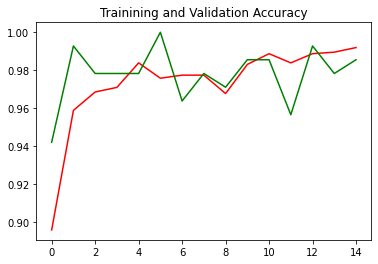

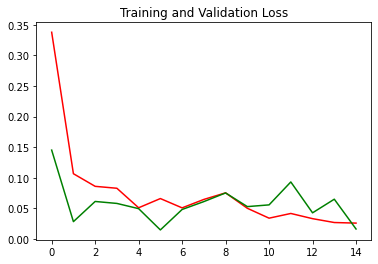

In [33]:
 train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(len(train_acc))

plt.plot(epochs, train_acc,'r', label='Train Accuracy' )
plt.plot(epochs, validation_acc, 'g', label = 'Validation Accuracy')
plt.title("Trainining and Validation Accuracy")

plt.figure()

plt.plot(epochs, train_loss, 'r', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'g', label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.show()

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/Mask Detection/mask_modelbig.h5')

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Mask Detection/mask_modelbig.h5')